In [10]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [40]:
df = pd.read_csv(r"/Users/dominikorzel-walker/Downloads/DailyDelhiClimate.csv")

df = df[:1462]

df.head(10)

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
5,2013-01-06,7.000000,82.800000,1.480000,1018.000000
6,2013-01-07,7.000000,78.600000,6.300000,1020.000000
7,2013-01-08,8.857143,63.714286,7.142857,1018.714286
8,2013-01-09,14.000000,51.250000,12.500000,1017.000000
9,2013-01-10,11.000000,62.000000,7.400000,1015.666667


In this example, we work on a more complex dataset to try and predict the mean temperatures. 

We use the same size training and test datasets for ARIMA, Random Forest Regressor and XGBoost Regressor here.

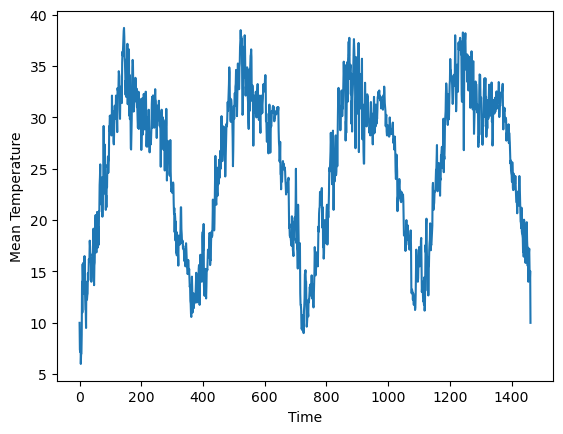

In [41]:
mean_temps = df.meantemp

plt.xlabel("Time")
plt.ylabel("Mean Temperature")
mean_temps.plot();

In [42]:
train_temps = mean_temps[: int(0.8 * len(mean_temps))]

test_temps = mean_temps[int(0.8 * len(mean_temps)) :]

# ARIMA Model

We do very much the same work as with the first dataset

In [43]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

In [44]:
adf = adfuller(mean_temps)
print(f"p-value: {adf[1]}")

p-value: 0.27741213723016156


Since the $p$-value is large, we must difference at least once

Since this data is much more complex, to produce a meaningful ARIMA model we in fact require two differencings

In [45]:
model_autoARIMA = auto_arima(train_temps, start_p = 0, start_q = 0, test = "adf", max_p = 12, max_q = 12, m = 1, d = 2, seasonal = False, start_P = 0, D = 0, trace = True, error_action = "ignore", suppress_warnings = True, stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=5496.317, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=5095.499, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=5494.317, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=4962.579, Time=0.06 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=4830.358, Time=0.08 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=4767.835, Time=0.13 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=4722.200, Time=0.17 sec
 ARIMA(6,2,0)(0,0,0)[0] intercept   : AIC=4687.384, Time=0.24 sec
 ARIMA(7,2,0)(0,0,0)[0] intercept   : AIC=4652.252, Time=0.41 sec
 ARIMA(8,2,0)(0,0,0)[0] intercept   : AIC=4637.729, Time=0.53 sec
 ARIMA(9,2,0)(0,0,0)[0] intercept   : AIC=4627.507, Time=0.71 sec
 ARIMA(10,2,0)(0,0,0)[0] intercept   : AIC=4591.786, Time=0.81 sec
 ARIMA(11,2,0)(0,0,0)[0] intercept   : AIC=4574.189, Time=0.90 sec
 ARIMA(12,2,0)(0,0,0)[0] intercept  

So we choose a $(9,2,2)$ model

In [46]:
model = ARIMA(train_temps, order = (9, 2, 2))

fitted = model.fit()

print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                 1169
Model:                 ARIMA(9, 2, 2)   Log Likelihood               -2205.439
Date:                Wed, 15 Jan 2025   AIC                           4434.879
Time:                        22:52:14   BIC                           4495.625
Sample:                             0   HQIC                          4457.793
                               - 1169                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6810      0.048     14.062      0.000       0.586       0.776
ar.L2          0.0296      0.032      0.925      0.355      -0.033       0.092
ar.L3         -0.0513      0.037     -1.391      0.1

In [47]:
forecast_temps = fitted.forecast(len(test_temps))

[]

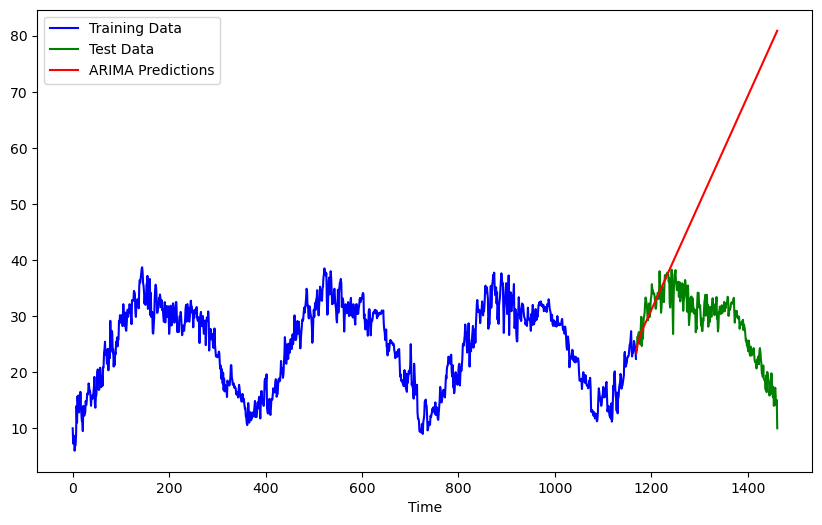

In [48]:
plt.figure(figsize = (10, 6))

plt.plot(train_temps, label = "Training Data", color = "blue")
plt.plot(test_temps, label = "Test Data", color = "green")
plt.plot(test_temps.index, forecast_temps, label = "ARIMA Predictions", color = "red")

plt.xlabel("Time")
plt.legend()

plt.plot()

So the ARIMA model can detect the short term upward trend, but cannot recognise the wider cyclic trend of the data, even after differencing twice

# Random Forest Regressor

For the machine learning models, we use the other features in the dataset to strengthen the model

In [49]:
from sklearn.ensemble import RandomForestRegressor

In [50]:
df_new = df.copy()

In [51]:
df_new.date = pd.to_datetime(df_new.date)
df_new["Year"] = df_new.date.dt.year
df_new["Month"] = df_new.date.dt.month
df_new["Day"] = df_new.date.dt.day

df_new.drop("date", axis = 1, inplace = True)

df_new.head(10)

,meantemp,humidity,wind_speed,meanpressure,Year,Month,Day
0,10.000000,84.500000,0.000000,1015.666667,2013,1,1
1,7.400000,92.000000,2.980000,1017.800000,2013,1,2
2,7.166667,87.000000,4.633333,1018.666667,2013,1,3
3,8.666667,71.333333,1.233333,1017.166667,2013,1,4
4,6.000000,86.833333,3.700000,1016.500000,2013,1,5
5,7.000000,82.800000,1.480000,1018.000000,2013,1,6
6,7.000000,78.600000,6.300000,1020.000000,2013,1,7
7,8.857143,63.714286,7.142857,1018.714286,2013,1,8
8,14.000000,51.250000,12.500000,1017.000000,2013,1,9
9,11.000000,62.000000,7.400000,1015.666667,2013,1,10


In [52]:
X_train = df_new.drop("meantemp", axis = 1).iloc[: int(0.8 * len(df.index))]
X_test = df_new.drop("meantemp", axis = 1).iloc[int(0.8 * len(df.index)): ]

y_train = df_new["meantemp"].iloc[: int(0.8 * len(df.index))]
y_test = df_new["meantemp"].iloc[int(0.8 * len(df.index)): ]

In [54]:
rfr = RandomForestRegressor(random_state = 32)

rfr.fit(X_train, y_train);

In [55]:
y_predictions = rfr.predict(X_test)

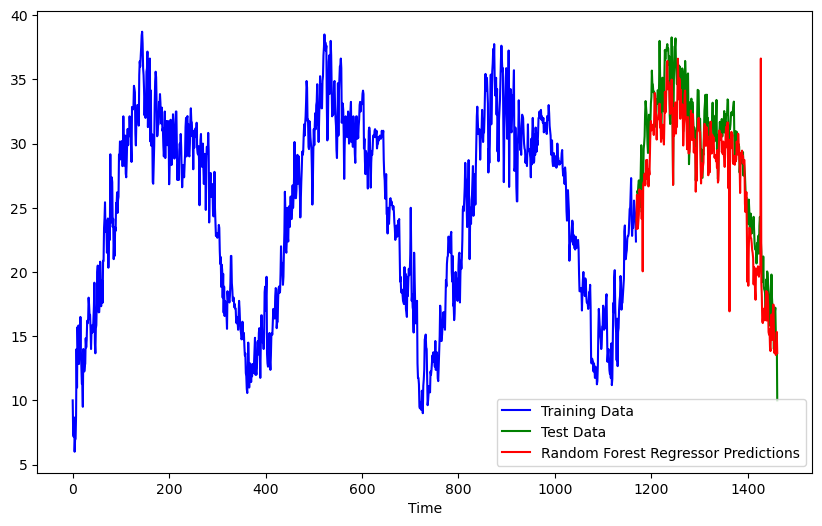

In [56]:
plt.figure(figsize = (10, 6))

plt.plot(y_train.index, y_train, label = "Training Data", color = "blue")
plt.plot(y_test.index, y_test, label = "Test Data", color = "green")
plt.plot(y_test.index, y_predictions, label = "Random Forest Regressor Predictions", color = "red")

plt.xlabel("Time")
plt.legend()

plt.plot();

The Random Forest Regressor notices the cylical pattern of the data very well, staying well in line most of the time apart from a few occasions

# XGBoost Regressor

In [57]:
from xgboost import XGBRegressor

In [59]:
xgbr = XGBRegressor()

xgbr.fit(X_train, y_train);

In [60]:
y_predictions = xgbr.predict(X_test)

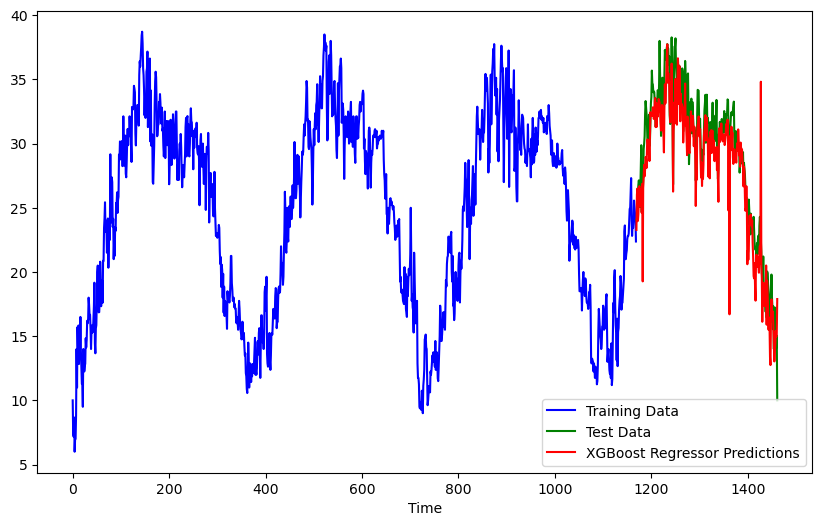

In [61]:
plt.figure(figsize = (10, 6))

plt.plot(y_train.index, y_train, label = "Training Data", color = "blue")
plt.plot(y_test.index, y_test, label = "Test Data", color = "green")
plt.plot(y_test.index, y_predictions, label = "XGBoost Regressor Predictions", color = "red")

plt.xlabel("Time")
plt.legend()

plt.plot();

XGBoost produces very similar results to the Random Forest for this dataset

### To conclude, we see that the machine learning models can handle this more complex dataset very well, using the additional features to their advantage. However, ARIMA clearly struggles to pick up the overarching trend of the data even after two differences and a large $p$ value, at which point it starts to become somewhat computationally expensive to compute predictions relative to their accuracy. Here, the machine learning models are much more powerful